In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius, BetaGaussianQuad

In [2]:
df = pd.read_csv('/Users/sophiasklaviadis/h181.csv')
# df_test_all = pd.read_csv('../data/MEPS_2018_house.csv')
# df_conf_all = pd.read_csv('../data/MEPS_2018_house.csv')

In [3]:
# df.RACEV2X

In [4]:
# df = df[df['RACEV2X'].isin(['1','2'])]
# df

In [5]:
import os

import pandas as pd


def default_preprocessing(df):
    df = df[df['RACEV2X'].isin([1,2])]
    df = df[df['HISPANX'] == 2]

    racedict = {1.0: 0.0,2.0: 1.0}
    df = df.assign(RACEV2X = df['RACEV2X'].replace(to_replace = racedict))
    df = df.rename(columns = {'RACEV2X' : 'RACE3'})

    genderdict = {1.0: 0.0,2.0: 1.0}
    df = df.assign(SEX = df['SEX'].replace(to_replace = genderdict))
    df = df.rename(columns = {'SEX' : 'GENDER'})
    df = df.rename(columns = {'PERWT15F' : 'PERSONWT'})
    df = df.rename(columns = {'REGION31' : 'REGION'})
    df = df.rename(columns = {'TTLP15X' : 'INCOME_M'})
    df = df.rename(columns = {'TOTEXP15' : 'HEALTHEXP'})

    # #df = df.drop('HISPANX',axis=1)  .column dropping can be taken care of by simply not including in features_to_keep
    # df = df[df['PANEL'] == 19]
    # #df = df.drop('PANEL',axis=1)
    # lessE = df['TOTEXP15'] <= 5000.0
    # df.loc[lessE,'TOTEXP15'] = 0.0
    # moreE = df['TOTEXP15'] > 5000.0
    # df.loc[moreE,'TOTEXP15'] = 1.0

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE31X'] >= 0] # remove values -1

    df = df[df['MARRY31X'] >= 0] # remove values -1, -7, -8, -9
    df = df[df['INCOME_M'] >= 0]

    df = df[(df[['EDRECODE','FTSTU31X','ACTDTY31','HONRDC31','RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX',
                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX',
                 'JTPAIN31','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31',
                 'ACTLIM31','SOCLIM31','COGLIM31','DFHEAR42','DFSEE42','ADSMOK42',
                 'PHQ242','EMPST31','POVCAT15','INSCOV15']] >= -1).all(1)]  #for all other categorical features, remove values < -1
    df = df[['PANEL', 'REGION','AGE31X','GENDER','RACE3','MARRY31X',     # dropped 'EDUCYR', 'HIDEG' as data distributions are weird across panels,
             'EDRECODE','FTSTU31X','ACTDTY31','HONRDC31','RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX',
             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX',
             'JTPAIN31','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31',
             'ACTLIM31','SOCLIM31','COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PCS42',
             'MCS42','K6SUM42','PHQ242','EMPST31','POVCAT15','INSCOV15','INCOME_M','HEALTHEXP','PERSONWT']]

    df['HEALTHEXP'].mean(), df['INCOME_M'].mean()
    return df


In [6]:
preproc_df = default_preprocessing(df)
preproc_df['HEALTHEXP']

0        46612
1         9207
3          808
4         2721
6         1573
         ...  
35400        0
35401    10088
35403        0
35413    31091
35423     2056
Name: HEALTHEXP, Length: 18350, dtype: int64

In [7]:
# Reset index to consecutive integers
preproc_df.reset_index(drop=True, inplace=True)
# Drop panel number (not meant to be predictive) and sample weights
# preproc_df.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)
preproc_df.head()

,PANEL,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,...,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP,PERSONWT
0,19,2,52,0,0,5,13,-1,2,2,...,25.93,58.47,3,0,4,1,2,11390.0,46612,21854.981705
1,19,2,55,1,0,3,14,-1,2,2,...,20.42,26.57,17,6,4,3,2,11390.0,9207,18169.604822
2,19,2,22,1,0,5,13,3,2,2,...,53.12,50.33,7,0,1,2,2,18000.0,808,17191.832515
3,19,2,2,0,0,6,-1,-1,3,3,...,-1.00,-1.00,-1,-1,-1,2,2,385.0,2721,20261.485463
4,19,3,25,1,0,1,14,-1,2,2,...,59.89,45.91,9,2,1,3,1,3700.0,1573,7620.222014


In [8]:
# Separate target variable
y = preproc_df.pop('HEALTHEXP')
# Split data into training and test sets
from sklearn.model_selection import train_test_split
df_Train, df_Test, y_Train, y_Test = train_test_split(preproc_df, y, random_state=0)

In [9]:
df_Train

,PANEL,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,PERSONWT
1955,19,3,50,1,1,1,2,-1,2,2,...,2,58.40,29.10,0,2,1,4,1,15332.0,3020.277072
5122,19,2,36,1,0,1,14,-1,2,2,...,1,56.15,57.16,0,0,1,4,1,38500.0,12004.804835
16933,20,3,7,0,0,6,1,-1,3,3,...,-1,-1.00,-1.00,-1,-1,-1,3,1,0.0,9774.560907
9837,20,2,32,1,0,1,16,-1,2,2,...,-1,-1.00,-1.00,-1,-1,1,5,1,99000.0,16531.533470
2865,19,2,10,0,1,6,1,-1,3,3,...,-1,-1.00,-1.00,-1,-1,-1,3,2,0.0,2831.702275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,20,3,33,1,1,5,15,-1,2,2,...,-1,-1.00,-1.00,-1,-1,1,5,1,101000.0,0.000000
13123,20,3,18,0,0,5,2,1,2,2,...,1,52.72,50.37,3,0,4,1,2,1913.0,4338.918743
9845,20,3,53,0,0,3,13,-1,2,2,...,1,56.15,57.16,2,0,1,4,1,25411.0,14603.949929
10799,20,3,28,1,1,5,14,-1,2,2,...,2,56.15,57.16,0,0,1,3,1,25000.0,8837.284899


In [10]:
from typing import Optional, Tuple, Union

import numpy as np
import pandas as pd
from numpy import ndarray
from pandas import DataFrame, Series
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier


# noinspection PyPep8Naming
class FeatureBinarizer(TransformerMixin):
    '''Transformer for binarizing categorical and ordinal features.
    
    For use with BooleanRuleCG, LogisticRuleRegression and LinearRuleRegression
    '''
    def __init__(self, colCateg=[], numThresh=9, negations=False, threshStr=False, returnOrd=False, **kwargs):
        """
        Args:
            colCateg (list): Categorical features ('object' dtype automatically treated as categorical)
            numThresh (int): Number of quantile thresholds used to binarize ordinal variables
            negations (bool): Append negations
            threshStr (bool): Convert thresholds on ordinal features to strings
            returnOrd (bool): Also return standardized ordinal features
        """
        # List of categorical columns
        if type(colCateg) is pd.Series:
            self.colCateg = colCateg.tolist()
        elif type(colCateg) is not list:
            self.colCateg = [colCateg]
        else:
            self.colCateg = colCateg
        # Number of quantile thresholds used to binarize ordinal features
        self.numThresh = numThresh
        self.thresh = {}
        # whether to append negations
        self.negations = negations
        # whether to convert thresholds on ordinal features to strings
        self.threshStr = threshStr
        # Also return standardized ordinal features
        self.returnOrd = returnOrd

    def fit(self, X):
        '''Fit FeatureBinarizer to data
        
        Args:
            X (DataFrame): Original features
        Returns:
            FeatureBinarizer: Self
            self.maps (dict): Mappings for unary/binary columns
            self.enc (dict): OneHotEncoders for categorical columns
            self.thresh (dict(array)): Thresholds for ordinal columns
            self.NaN (list): Ordinal columns containing NaN values
            self.ordinal (list): Ordinal columns
            self.scaler (StandardScaler): StandardScaler for ordinal columns
        '''
        data = X
        # Quantile probabilities
        quantProb = np.linspace(1. / (self.numThresh + 1.), self.numThresh / (self.numThresh + 1.), self.numThresh)
        # Initialize
        maps = {}
        enc = {}
        thresh = {}
        NaN = []
        if self.returnOrd:
            ordinal = []

        # Iterate over columns
        for c in data:
            # number of unique values
            valUniq = data[c].nunique()

            # Constant or binary column
            if valUniq <= 2:
                # Mapping to 0, 1
                maps[c] = pd.Series(range(valUniq), index=np.sort(data[c].dropna().unique()))

            # Categorical column
            elif (c in self.colCateg) or (data[c].dtype == 'object'):
                # OneHotEncoder object
                enc[c] = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
                # Fit to observed categories
                enc[c].fit(data[[c]])

            # Ordinal column
            elif np.issubdtype(data[c].dtype, np.integer) | np.issubdtype(data[c].dtype, np.floating):
                # Few unique values
                if valUniq <= self.numThresh + 1:
                    # Thresholds are sorted unique values excluding maximum
                    thresh[c] = np.sort(data[c].unique())[:-1]
                # Many unique values
                else:
                    # Thresholds are quantiles excluding repetitions
                    thresh[c] = data[c].quantile(q=quantProb).unique()
                if data[c].isnull().any():
                    # Contains NaN values
                    NaN.append(c)
                if self.returnOrd:
                    ordinal.append(c)

            else:
                print(("Skipping column '" + str(c) + "': data type cannot be handled"))
                continue

        self.maps = maps
        self.enc = enc
        self.thresh = thresh
        self.NaN = NaN
        if self.returnOrd:
            self.ordinal = ordinal
            # Fit StandardScaler to ordinal features
            self.scaler = StandardScaler().fit(data[ordinal])
        return self

    def transform(self, X):
        '''Binarize features
        
        Args:
            X (DataFrame): Original features
        Returns:
            A (DataFrame): Binarized features with MultiIndex column labels
            Xstd (DataFrame, optional): Standardized ordinal features
        '''
        data = X
        maps = self.maps
        enc = self.enc
        thresh = self.thresh
        NaN = self.NaN

        # Initialize dataframe
        A = pd.DataFrame(index=data.index,
                         columns=pd.MultiIndex.from_arrays([[], [], []], names=['feature', 'operation', 'value']))

        # Iterate over columns
        for c in data:
            # Constant or binary column
            if c in maps:
                # Rename values to 0, 1
                colName = (str(c), '!=', str(maps[c].index[0])) if len(maps[c]) == 1 else (str(c), '==', str(maps[c].index[1]))
                A[colName] = data[c].map(maps[c]).astype(int)
                if self.negations:
                    A[(str(c), '==', str(maps[c].index[0]))] = 1 - A[colName]

            # Categorical column
            elif c in enc:
                # Apply OneHotEncoder
                Anew = enc[c].transform(data[[c]])
                Anew = pd.DataFrame(Anew, index=data.index, columns=enc[c].categories_[0].astype(str))
                if self.negations:
                    # Append negations
                    Anew = pd.concat([Anew, 1 - Anew], axis=1, keys=[(str(c), '=='), (str(c), '!=')])
                else:
                    Anew.columns = pd.MultiIndex.from_product([[str(c)], ['=='], Anew.columns])
                # Concatenate
                A = pd.concat([A, Anew], axis=1)

            # Ordinal column
            elif c in thresh:
                # Threshold values to produce binary arrays
                Anew = (data[c].values[:, np.newaxis] <= thresh[c]).astype(int)
                if self.negations:
                    # Append negations
                    Anew = np.concatenate((Anew, 1 - Anew), axis=1)
                    ops = ['<=', '>']
                else:
                    ops = ['<=']
                # Convert to dataframe with column labels
                if self.threshStr:
                    Anew = pd.DataFrame(Anew, index=data.index,
                                        columns=pd.MultiIndex.from_product([[str(c)], ops, thresh[c].astype(str)]))
                else:
                    Anew = pd.DataFrame(Anew, index=data.index,
                                        columns=pd.MultiIndex.from_product([[str(c)], ops, thresh[c]]))
                if c in NaN:
                    # Ensure that rows corresponding to NaN values are zeroed out
                    indNull = data[c].isnull()
                    Anew.loc[indNull] = 0
                    # Add NaN indicator column
                    Anew[(str(c), '==', 'NaN')] = indNull.astype(int)
                    if self.negations:
                        Anew[(str(c), '!=', 'NaN')] = (~indNull).astype(int)
                # Concatenate
                A = pd.concat([A, Anew], axis=1)

            else:
                print(("Skipping column '" + str(c) + "': data type cannot be handled"))
                continue

        if self.returnOrd:
            # Standardize ordinal features
            Xstd = self.scaler.transform(data[self.ordinal])
            Xstd = pd.DataFrame(Xstd, index=data.index, columns=self.ordinal)
            # Fill NaN with mean (which is now zero)
            Xstd.fillna(0, inplace=True)
            return A, Xstd
        else:
            return A

In [11]:
# Categorical features
colCateg = ['REGION','MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15']
# Binarize data and also return standardized ordinal features
fb = FeatureBinarizer(colCateg=colCateg, negations=True, returnOrd=True)
df_Train, df_TrainStd = fb.fit_transform(df_Train)
df_Test, df_TestStd = fb.transform(df_Test)

In [12]:
df_Train

PANEL    REGION                       ...    PERSONWT             \
         ==        ==          !=           ...          <=          >   
         20 19      1  2  3  4  1  2  3  4  ... 22998.31384 3216.98406   
1955      0  1      0  0  1  0  1  1  0  1  ...           1          0   
5122      0  1      0  1  0  0  1  0  1  1  ...           1          1   
16933     1  0      0  0  1  0  1  1  0  1  ...           1          1   
9837      1  0      0  1  0  0  1  0  1  1  ...           1          1   
2865      0  1      0  1  0  0  1  0  1  1  ...           1          0   
...     ... ..    ... .. .. .. .. .. .. ..  ...         ...        ...   
9225      1  0      0  0  1  0  1  1  0  1  ...           1          0   
13123     1  0      0  0  1  0  1  1  0  1  ...           1          1   
9845      1  0      0  0  1  0  1  1  0  1  ...           1          1   
10799     1  0      0  0  1  0  1  1  0  1  ...           1          1   
2732      0  1      0  0  1  0  1  1  0  1  ...           1          1   

                                                                   \
                                                                    
      4692.622393 6273.126657 8048.73954 9836.815139 11730.761868   
1955            0           0          0           0            0   
5122            1           1          1           1            1   
16933           1           1          1           0            0   
9837            1           1          1           1            1   
2865            0           0          0           0            0   
...           ...         ...        ...         ...          ...   
9225            0           0          0           0            0   
13123           0           0          0           0            0   
9845            1           1          1           1            1   
10799           1           1          1           0            0   
2732            1           1          1           1            1   

                                             
                                             
      13999.149516 17290.291688 22998.31384  
1955             0            0           0  
5122             0            0           0  
16933            0            0           0  
9837             1            0           0  
2865             0            0           0  
...            ...          ...         ...  
9225             0            0           0  
13123            0            0           0  
9845             1            0           0  
10799            0            0           0  
2732             1            0           0  

[13762 rows x 376 columns]

In [13]:
y_Train

1955      6233
5122       776
16933      140
9837     23440
2865         0
         ...  
9225        79
13123     1140
9845       624
10799      322
2732     12634
Name: HEALTHEXP, Length: 13762, dtype: int64

In [14]:
# df_Train = df_Train.dropna()
# df_Train

In [15]:
y.describe(percentiles=np.linspace(0.1, 0.9, 9))

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
10%           0.000000
20%         114.000000
30%         302.000000
40%         585.000000
50%        1034.000000
60%        1784.800000
70%        3099.000000
80%        5619.800000
90%       12591.100000
max      659952.000000
Name: HEALTHEXP, dtype: float64

In [16]:
# Train and evaluate GBRT
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=500, random_state=0)
gbr.fit(df_Train, y_Train)
from sklearn.metrics import r2_score
print('Training R^2:', r2_score(y_Train, gbr.predict(df_Train)))
print('Test R^2:', r2_score(y_Test, gbr.predict(df_Test)))

Training R^2: 0.5214287651206889
Test R^2: 0.11013222596490346


In [17]:
df_Train = df_Train.set_index(df_Train.index)

# df_Train.iloc[:,1].values
df_Train['bias']= '1'
df_Train

PANEL    REGION                       ...   PERSONWT              \
         ==        ==          !=           ...          >               
         20 19      1  2  3  4  1  2  3  4  ... 3216.98406 4692.622393   
1955      0  1      0  0  1  0  1  1  0  1  ...          0           0   
5122      0  1      0  1  0  0  1  0  1  1  ...          1           1   
16933     1  0      0  0  1  0  1  1  0  1  ...          1           1   
9837      1  0      0  1  0  0  1  0  1  1  ...          1           1   
2865      0  1      0  1  0  0  1  0  1  1  ...          0           0   
...     ... ..    ... .. .. .. .. .. .. ..  ...        ...         ...   
9225      1  0      0  0  1  0  1  1  0  1  ...          0           0   
13123     1  0      0  0  1  0  1  1  0  1  ...          1           0   
9845      1  0      0  0  1  0  1  1  0  1  ...          1           1   
10799     1  0      0  0  1  0  1  1  0  1  ...          1           1   
2732      0  1      0  0  1  0  1  1  0  1  ...          1           1   

                                                                    \
                                                                     
      6273.126657 8048.73954 9836.815139 11730.761868 13999.149516   
1955            0          0           0            0            0   
5122            1          1           1            1            0   
16933           1          1           0            0            0   
9837            1          1           1            1            1   
2865            0          0           0            0            0   
...           ...        ...         ...          ...          ...   
9225            0          0           0            0            0   
13123           0          0           0            0            0   
9845            1          1           1            1            1   
10799           1          1           0            0            0   
2732            1          1           1            1            1   

                               bias  
                                     
      17290.291688 22998.31384       
1955             0           0    1  
5122             0           0    1  
16933            0           0    1  
9837             0           0    1  
2865             0           0    1  
...            ...         ...  ...  
9225             0           0    1  
13123            0           0    1  
9845             0           0    1  
10799            0           0    1  
2732             0           0    1  

[13762 rows x 377 columns]

In [18]:
# df_Train = df_Train.dropna()
# df_Train
print(df_Train.iloc[1955].to_string())

PANEL     ==   20              1
               19              0
REGION    ==   1               0
               2               0
               3               1
               4               0
          !=   1               1
               2               1
               3               0
               4               1
AGE31X    <=   7.0             0
               14.0            0
               23.0            0
               31.0            0
               38.0            0
               47.0            0
               54.0            0
               61.0            0
               70.0            1
          >    7.0             1
               14.0            1
               23.0            1
               31.0            1
               38.0            1
               47.0            1
               54.0            1
               61.0            1
               70.0            0
GENDER    ==   1               1
               0               0
RACE3     

In [19]:
ols = sm.OLS(y_Train, df_Train.astype(float))
ols_result = ols.fit()

In [20]:
ols_result.mse_model

4093125863.9351373

In [ ]:
# residuals of a LM are dependent on X
# plt.scatter(X.EngDispl, ols_result.resid)
# too big to run?
# het_white(ols_result.resid, df_Train.astype(float))
# het_breuschpagan(ols_result.resid, df_Train.astype(float), robust=False)

In [21]:
torch.set_default_dtype(torch.double)

In [22]:
X_train = torch.from_numpy(df_Train.astype(float).to_numpy())[:, :-1] #.unsqueeze(-1)
X_train = X_train.type(torch.double)
y_train = torch.from_numpy(y_Train.to_numpy()).squeeze()
y_train = y_train.type(torch.double)

X_test = torch.from_numpy(df_Test.astype(float).to_numpy()) #.unsqueeze(-1)
X_test = X_test.type(torch.double)
y_test = torch.from_numpy(y_Test.to_numpy()).squeeze()
y_test = y_test.type(torch.double)


In [23]:
X_train.dtype

torch.float64

In [24]:
# normalize inputs (?)
mu = X_train.mean(dim=0)
std = torch.norm(X_train - mu, dim=0)
# mu
# # std

In [29]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std

In [30]:
X_test.shape, X_train.shape 

(torch.Size([4588, 376]), torch.Size([13762, 376]))

In [31]:
X_train

tensor([[-0.0092, -0.0079, -0.0038,  ..., -0.0057, -0.0044, -0.0029],
        [-0.0092, -0.0079, -0.0038,  ..., -0.0057, -0.0044, -0.0029],
        [-0.0089, -0.0082, -0.0038,  ..., -0.0057, -0.0044, -0.0029],
        ...,
        [-0.0089, -0.0082, -0.0038,  ..., -0.0053, -0.0044, -0.0029],
        [-0.0089, -0.0082, -0.0038,  ..., -0.0057, -0.0044, -0.0029],
        [-0.0092, -0.0079, -0.0038,  ..., -0.0053, -0.0044, -0.0029]])

In [37]:
# def save_for_plot(model):
#     alpha = model.alpha
#     model.eval()
    
#     # t = torch.linspace(X_torch[:, 1].min(), X_torch[:, 1].max() +0.1 , 100).unsqueeze(-1)
#     # print(t.shape)
#     with torch.no_grad():
    
#         y_pred, sigma_sq = model(X_train[:200,:])
#         std_pred = sigma_sq.sqrt()
    
#     # t = t.squeeze().numpy()
#     y_pred = y_pred.squeeze().numpy()
#     std_pred = std_pred.squeeze().numpy()

#     if alpha == 1:
#         # 95% confidence interval.
#         a = 2*std_pred
#     else:
#         # 100% confidence interval.
#         R = _radius(1, alpha)
#         tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
#         a = np.sqrt(-2 * tau * std_pred**2)
        
#     return X_train[:200,0], y_pred, a
    

# def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
#     ax.plot(t, y_pred, color='C0', label="predicted mean")

#     ax.fill_between(t,
#                     y_pred - a,
#                     y_pred + a,
#                     alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
#     # Plot the truth
#     ax.scatter(((X_train[:200,1]+X_train[:200,0]+X_train[:200,2])/3).squeeze().numpy(), y_train[:200].squeeze().numpy(), marker='.', color='C1', label='train')
#     # ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

#     # ax.set_ylim(-10, 370)
#     ax.set_xlim(None, t[-1])
    
# def save_for_conf(model):
#     alpha = model.alpha
#     model.eval()
    
#     with torch.no_grad():
    
#         y_pred_test, sigma_sq_test = model(X_test)
#         std_pred_test = sigma_sq_test.sqrt()
    
#     y_pred_test = y_pred_test.squeeze().numpy()
#     std_pred_test = std_pred_test.squeeze().numpy()

#     if alpha == 1:
#         # 95% confidence interval.
#         a_test = 2*std_pred_test
#     else:
#         # 100% confidence interval.
#         R_test = _radius(1, alpha)
#         tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
#         a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

#     return y_test, y_pred_test, a_test, 

X_torch = torch.cat((X_train, X_test))
y_torch = torch.cat((y_train, y_test))

def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    # t = torch.linspace(X_torch.min(), X_torch.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(X_torch)
        std_pred = sigma_sq.sqrt()
    
    # t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return X_torch, y_pred, a

def save_for_conf(model):
    alpha = model.alpha
    model.eval()
    
    t_test = torch.linspace(X_test.min(), X_test.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred_test, sigma_sq_test = model(X_test)
        std_pred_test = sigma_sq_test.sqrt()
    
    # t_test = t_test.squeeze().numpy()
    y_pred_test = y_pred_test.squeeze().numpy()
    std_pred_test = std_pred_test.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_test = 2*std_pred_test
    else:
        # 100% confidence interval.
        R_test = _radius(1, alpha)
        tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
        a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

    return y_test, y_pred_test, a_test, X_test.squeeze().numpy()

def plot_model(t, y_pred, a, ax, res_conf, which="support", fill_color='C0', fill_color1='C0',):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='crimson', label='train',alpha=0.6, s=13)

    preds = res_conf[1][:, None]
    sigmas = res_conf[2][:, None]/2
    trues = res_conf[0][:, None].numpy()
    x = res_conf[3][:, None]
    
    pred_test = preds[100:]
    true_test = trues[100:]
    sigma_test = sigmas[100:]
    x_test = x[100:]
    
    pred_cal = preds[:100]
    true_cal = trues[:100]
    sigma_cal = sigmas[:100]
    x_cal = x[:100]
    
    n_test = true_test.shape[0]
    n_cal = true_cal.shape[0]
    
    # scores
    
    cal_scores = np.abs(pred_cal-true_cal)/sigma_cal
    test_scores = np.abs(pred_test-true_test)/sigma_test
    
    alpha = 0.1
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method
    
    # test predictions
    test_intervals = np.zeros((n_test,2))
    test_intervals[:,0:1] = pred_test-qhat*sigma_test
    test_intervals[:,1:] = pred_test+qhat*sigma_test
    
    coverage = ((true_test<=test_intervals[:,1:]) & (true_test>=test_intervals[:,0:1])).sum()/n_test

    df = pd.DataFrame({'x':x_test[:,0],
                       'lower': test_intervals[:,0],
                       'upper':test_intervals[:,1]})
    
    df.sort_values(by = 'x', inplace = True)
    ax.fill_between(df['x'],
                    df['lower'],
                    df['upper'],
                    alpha=0.2, color=fill_color1, label='calibrated test')

    # Plot the truth
    ax.scatter(x_cal, true_cal, marker='x', color='darkgreen', label='cal', alpha=0.6, s=13)
    ax.scatter(x_test, true_test, marker='*', color='royalblue', label='test', alpha=0.6, s=13)
    # ax.set_ylim(-10, 350)
    ax.set_xlim(None, df['x'].to_numpy()[-1]) # min(df['x'].to_numpy())

In [38]:
# X_train[:, 1].squeeze().shape

In [33]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianLM(input_size=376, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)
# print("w", bl_model.lin.weight.data, "b", bl_model.lin.bias.data)

R2 train -3.607 test -5.170
w tensor([[-1.0071e+06,  1.0121e+06,  1.5340e+06,  4.3591e+05, -9.0193e+05,
         -4.4299e+05, -1.5271e+06, -4.3010e+05,  9.0701e+05,  4.4966e+05,
         -2.2381e+05,  4.0455e+05,  3.5747e+05,  1.2199e+05, -1.3997e+06,
          3.8417e+05, -2.8782e+05,  5.1702e+05,  6.5631e+05,  2.3210e+05,
         -3.9828e+05, -3.5202e+05, -1.1690e+05,  1.4048e+06, -3.7902e+05,
          2.9336e+05, -5.1061e+05, -6.4769e+05,  9.5201e+04, -9.0178e+04,
         -7.7021e+05,  7.7550e+05, -5.2508e+05,  1.1811e+05,  2.0315e+05,
          2.3677e+05,  3.3894e+05,  1.9331e+05, -2.7709e+04, -9.1409e+04,
          8.5534e+04, -6.4337e+04,  5.3033e+05, -1.0653e+05, -1.9414e+05,
         -2.1469e+05, -3.3317e+05, -1.8718e+05,  5.2528e+04,  1.2856e+05,
         -6.3398e+04,  9.5282e+04, -9.2610e+05, -1.9958e+06, -5.9168e+05,
         -1.3740e+04,  1.1746e+06,  9.3328e+05,  1.0616e+06,  9.3628e+05,
          2.0025e+06,  6.0044e+05,  1.9513e+04, -1.1685e+06, -9.2587e+05,
        

In [39]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []
res_conf= []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    for seed in [42,  ]: # 43, 44, 45, 46
        torch.manual_seed(seed)
        model = BetaGaussianLM(input_size=376, uncertainty=True, heteroscedastic=True, alpha=alpha)

        model.pred_y.weight.data[:] = bl_model.pred_y.weight
        model.pred_y.bias.data[:] = bl_model.pred_y.bias
        
        # model.lin.weight.data[:] = bl_model.lin.weight
        # model.lin.bias.data[:] = bl_model.lin.bias
        # model.quad.weight.data[:] = bl_model.quad.weight
        # model.quad.bias.data[:] = bl_model.quad.bias
        
        optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
        
        for epoch in range(n_epochs):
            
            def closure():
                optimizer.zero_grad()
                model.train()
                loss = model.loss(X_train, y_train)
                loss.backward()
                return loss
            
            optimizer.step(closure)
                
        # evaluate R^2
        model.eval()
        y_pred_train = model.predict(X_train).detach().numpy()
        y_pred_test = model.predict(X_test).detach().numpy()
    
        r2 = "R2 train {:.3f} test {:.3f}".format(
            r2_score(y_pred_train, y_train.numpy()),
            r2_score(y_pred_test, y_test.numpy()))

        print(alpha, r2)
        results.append((alpha, save_for_plot(model), r2)) #
        res_conf.append(save_for_conf(model))


1 R2 train -3.607 test -5.170
1.3333333333333333 R2 train -3.608 test -5.172
1.5 R2 train -3.615 test -5.176
2 R2 train -3.613 test -5.178


In [ ]:
# len(results[0][1][0]), len(results[0][1][1]), len(results[0][1][2])

In [ ]:
# results[3][1]

In [ ]:
# fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

# plt.rcParams['legend.title_fontsize'] = 12
# plt.rcParams['legend.fancybox'] = False
# plt.rcParams['legend.frameon'] = False
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12

# plot_model(*results[0][1], ax_gauss, res_conf[0], "95% CI", fill_color='skyblue', fill_color1='midnightblue' )
# plot_model(*results[3][1], ax_tp, res_conf[3], "support", fill_color='yellowgreen', fill_color1='darkgreen')
# ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2: train = 0.527, test = 0.530$", fontsize=11)
# ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2: train = 0.534, test = 0.541$", fontsize=11)
# ax_gauss.set_ylabel(" Fuel Efficiency ", fontsize=12)
# ax_gauss.set_xlabel("EngDisplacement ", fontsize=12)
# ax_tp.set_xlabel("EngDisplacement", fontsize=12)
# plt.savefig("cars.pdf")

Coverage:0.9436274509803921
Coverage FY:0.9456327985739751
Avg width: 31839.899940331816
Avg width FY: 32817.52932115439


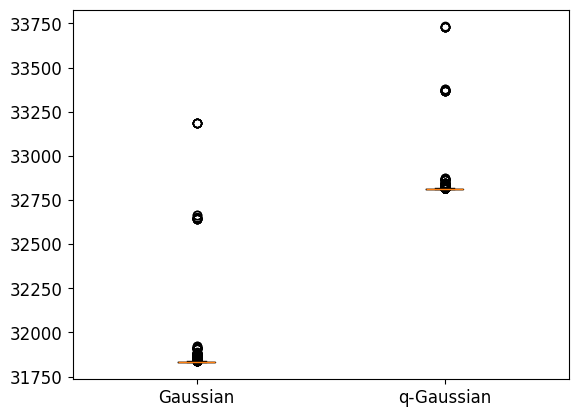

In [41]:
preds = res_conf[0][1][:, None]
sigmas = res_conf[0][2][:, None]/2
trues = res_conf[0][0][:, None].numpy()
x = res_conf[0][3][:, None]

pred_test = preds[100:]
true_test = trues[100:]
sigma_test = sigmas[100:]
x_test = x[100:]

pred_cal = preds[:100]
true_cal = trues[:100]
sigma_cal = sigmas[:100]
x_cal = x[:100]

n_test = true_test.shape[0]
n_cal = true_cal.shape[0]

# scores

cal_scores = np.abs(pred_cal-true_cal)/sigma_cal
test_scores = np.abs(pred_test-true_test)/sigma_test

alpha = 0.1
q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method

# test predictions
test_intervals = np.zeros((n_test,2))
test_intervals[:,0:1] = pred_test-qhat*sigma_test
test_intervals[:,1:] = pred_test+qhat*sigma_test

coverage = ((true_test<=test_intervals[:,1:]) & (true_test>=test_intervals[:,0:1])).sum()/n_test

# print(f'Coverage:{coverage}')
widths = test_intervals[:,1]-test_intervals[:,0]
avg_width = widths.mean()

# plt.boxplot(widths)
# print(f'Avg width: {avg_width}')

preds_fy = res_conf[3][1][:, None]
sigmas_fy = res_conf[3][2][:, None]/2
trues_fy = res_conf[3][0][:, None].numpy()
x_fy = res_conf[3][3][:, None]

pred_test_fy = preds_fy[100:]
true_test_fy = trues_fy[100:]
sigma_test_fy = sigmas_fy[100:]
x_test_fy = x_fy[100:]

pred_cal_fy = preds_fy[:100]
true_cal_fy = trues_fy[:100]
sigma_cal_fy = sigmas_fy[:100]
x_cal_fy = x_fy[:100]

n_test_fy = true_test_fy.shape[0]
n_cal_fy = true_cal_fy.shape[0]

# scores

cal_scores_fy = np.abs(pred_cal_fy-true_cal_fy)/sigma_cal_fy
test_scores_fy = np.abs(pred_test_fy-true_test_fy)/sigma_test_fy

alpha_fy = 0.1
q_level_fy = np.ceil((n_cal_fy+1)*(1-alpha_fy))/n_cal_fy
qhat_fy = np.quantile(cal_scores_fy, q_level_fy, method = 'higher') # check quantile method

# test predictions
test_intervals_fy = np.zeros((n_test_fy,2))
test_intervals_fy[:,0:1] = pred_test_fy-qhat_fy*sigma_test_fy
test_intervals_fy[:,1:] = pred_test_fy+qhat_fy*sigma_test_fy

coverage_fy = ((true_test_fy<=test_intervals_fy[:,1:]) & (true_test_fy>=test_intervals_fy[:,0:1])).sum()/n_test_fy


print(f'Coverage:{coverage}')
widths = test_intervals[:,1]-test_intervals[:,0]
avg_width = widths.mean()

print(f'Coverage FY:{coverage_fy}')
widths_fy = test_intervals_fy[:,1]-test_intervals_fy[:,0]
avg_width_fy = widths_fy.mean()

plt.boxplot([widths, widths_fy], labels=('Gaussian', 'q-Gaussian'))
plt.savefig("cars_boxes.pdf")
print(f'Avg width: {avg_width}')
print(f'Avg width FY: {avg_width_fy}')


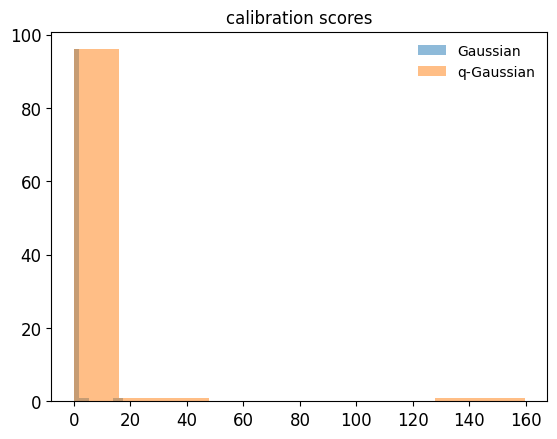

In [42]:
plt.hist(cal_scores, alpha=0.5, label='Gaussian' )
plt.hist(cal_scores_fy, alpha=0.5, label='q-Gaussian' )
plt.legend(loc='upper right')
plt.title('calibration scores')
plt.savefig("cars_hist.pdf")